# Pytorch Revisit

## outline

- Datasets
- Models
- Losses
- Optimizers

In [5]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams.update({'font.size': 16})


The data are obtained from the model 
$$
x \mapsto y:=Ax + b
$$
with $x\in\mathbb R^{input\_dim}$ and $y\in\mathbb R^{output\_dim}$.

In [2]:
# Generating a linear dataset
input_dim = 1
output_dim = 1

A = 2 * np.random.rand(output_dim, input_dim) - 1
b = 2 * np.random.rand(output_dim) - 1

true_model = lambda x: A @ x + b

We get a training set by randomly sampling and noisy observations
\begin{align*}
&x_i \sim U([-1, 1])\\
&y_i = A x_i + b + \nu_i
\end{align*}

In [3]:
n_train = 1000
noise_level = 0.04

# Generate a random set of n_train samples
X_train = np.random.rand(n_train, input_dim)
y_train = np.array([true_model(x) for x in X_train])

# Add some noise
y_train += noise_level * np.random.standard_normal(size=y_train.shape)

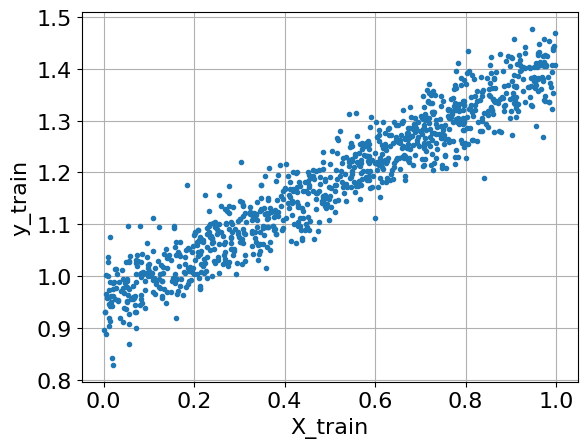

In [4]:
if input_dim == output_dim == 1:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.plot(X_train, y_train, '.')
    ax.grid(True)
    ax.set_xlabel('X_train')
    ax.set_ylabel('y_train')

## PyTorch `Dataset`

In [6]:
# convert to torch tensors

class VectoricalDataset(torch.utils.data.Dataset):
    """Converts a dataset of vectors to a dataset of torch tensors"""
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.X[idx], self.y[idx]

In [7]:
training_set = VectoricalDataset(X_train, y_train)
print(len(training_set))

1000


## PyTorch `DataLoader`

In [9]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)

The role of `batch_size`:

In [10]:
for idx, batch in enumerate(train_loader):
    print('Batch n. %2d: input size=%s, output size=%s' % (idx+1, batch[0].shape, batch[1].shape))

Batch n.  1: input size=torch.Size([100, 1]), output size=torch.Size([100, 1])
Batch n.  2: input size=torch.Size([100, 1]), output size=torch.Size([100, 1])
Batch n.  3: input size=torch.Size([100, 1]), output size=torch.Size([100, 1])
Batch n.  4: input size=torch.Size([100, 1]), output size=torch.Size([100, 1])
Batch n.  5: input size=torch.Size([100, 1]), output size=torch.Size([100, 1])
Batch n.  6: input size=torch.Size([100, 1]), output size=torch.Size([100, 1])
Batch n.  7: input size=torch.Size([100, 1]), output size=torch.Size([100, 1])
Batch n.  8: input size=torch.Size([100, 1]), output size=torch.Size([100, 1])
Batch n.  9: input size=torch.Size([100, 1]), output size=torch.Size([100, 1])
Batch n. 10: input size=torch.Size([100, 1]), output size=torch.Size([100, 1])


The role of `shuffle`:

In [11]:
first_batch = []

for epoch in range(2):
    for idx, batch in enumerate(train_loader):
        if idx == 0:
            first_batch.append(batch)
        
np.c_[X_train[:batch_size], first_batch[0][0].numpy(), first_batch[1][0].numpy()]

array([[0.24046258, 0.90305912, 0.58669752],
       [0.62243628, 0.35396135, 0.41521975],
       [0.2774773 , 0.49456248, 0.72990888],
       [0.91259359, 0.38084516, 0.54422563],
       [0.25600179, 0.0253892 , 0.81595427],
       [0.00516193, 0.64661729, 0.41620377],
       [0.56311208, 0.61283433, 0.72497964],
       [0.35610321, 0.90012866, 0.90012866],
       [0.33926392, 0.342724  , 0.21314009],
       [0.54902594, 0.9376232 , 0.63102412],
       [0.05336676, 0.77441025, 0.80940872],
       [0.48288238, 0.670358  , 0.02500383],
       [0.5644676 , 0.34770387, 0.15163295],
       [0.07203069, 0.8729338 , 0.58051389],
       [0.98494965, 0.42977735, 0.2411522 ],
       [0.99797575, 0.48467574, 0.85065699],
       [0.04994534, 0.26340005, 0.57336849],
       [0.38066485, 0.89847565, 0.22831166],
       [0.18245401, 0.58712941, 0.70927298],
       [0.65136088, 0.66055381, 0.41122061],
       [0.38891339, 0.36348176, 0.23602195],
       [0.1221075 , 0.54619306, 0.0206562 ],
       [0.

## Linear Regression

We implement a linear model $$x \mapsto model(x):=A x + b$$ 

with $A\in \mathbb{R}^{input\_dim\times output\_dim}$, $b\in\mathbb{R}^{output\_dim}$.

In [12]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.linear = nn.Linear(self.input_dim, self.output_dim, bias=True)

    def forward(self, x):
        out = self.linear(x)
        return out
    
    def reset(self):
        self.linear.reset_parameters()

In [13]:
model = LinearModel(input_dim, output_dim)

In [14]:
# print some information about the model
print(model)
print('Parameters:', list(model.parameters()))
print('Input shape:', model.linear.weight.shape)
print('weight:', model.linear.weight)
print('bias:', model.linear.bias)

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
Parameters: [Parameter containing:
tensor([[-0.1556]], requires_grad=True), Parameter containing:
tensor([-0.2930], requires_grad=True)]
Input shape: torch.Size([1, 1])
weight: Parameter containing:
tensor([[-0.1556]], requires_grad=True)
bias: Parameter containing:
tensor([-0.2930], requires_grad=True)


## Forward `Method`

In [15]:
x = torch.randn(5, input_dim)
model(x)

tensor([[-0.3189],
        [-0.3260],
        [-0.0571],
        [-0.3215],
        [ 0.0925]], grad_fn=<AddmmBackward0>)

In [16]:
[model.linear.weight @ xx + model.linear.bias for xx in x]

[tensor([-0.3189], grad_fn=<AddBackward0>),
 tensor([-0.3260], grad_fn=<AddBackward0>),
 tensor([-0.0571], grad_fn=<AddBackward0>),
 tensor([-0.3215], grad_fn=<AddBackward0>),
 tensor([0.0925], grad_fn=<AddBackward0>)]

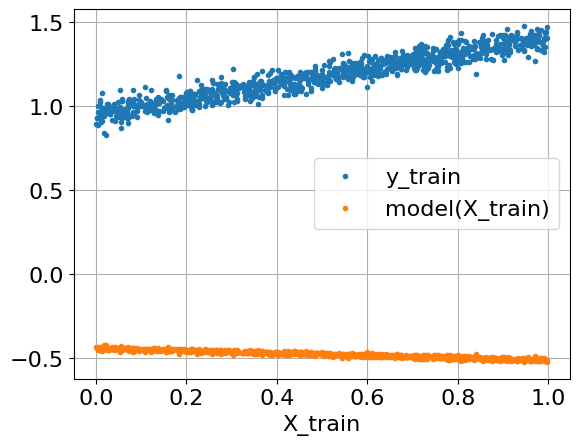

In [18]:
if input_dim == output_dim == 1:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.plot(training_set.X, training_set.y, '.')
    ax.plot(training_set.X, model.forward(training_set.y).detach().numpy(), '.')
    ax.grid(True)
    ax.set_xlabel('X_train')
    ax.legend(['y_train', 'model(X_train)'])    

# Losses
The MSE loss is
$$
L(y, y') = \|y-y'\|_2^2
$$

In [19]:
loss_fun = nn.MSELoss(reduction='mean')

The loss for one data pair $(x_i, y_i)$ is 
$$
L(model(x_i), y_i)
$$

The cumulative (average) loss on the training set is 
$$
L(X_{train}, y_{train}):=\frac{1}{n_{train}} \sum_{i=1}^{n_{train}} L(model(x_i), y_i)
$$

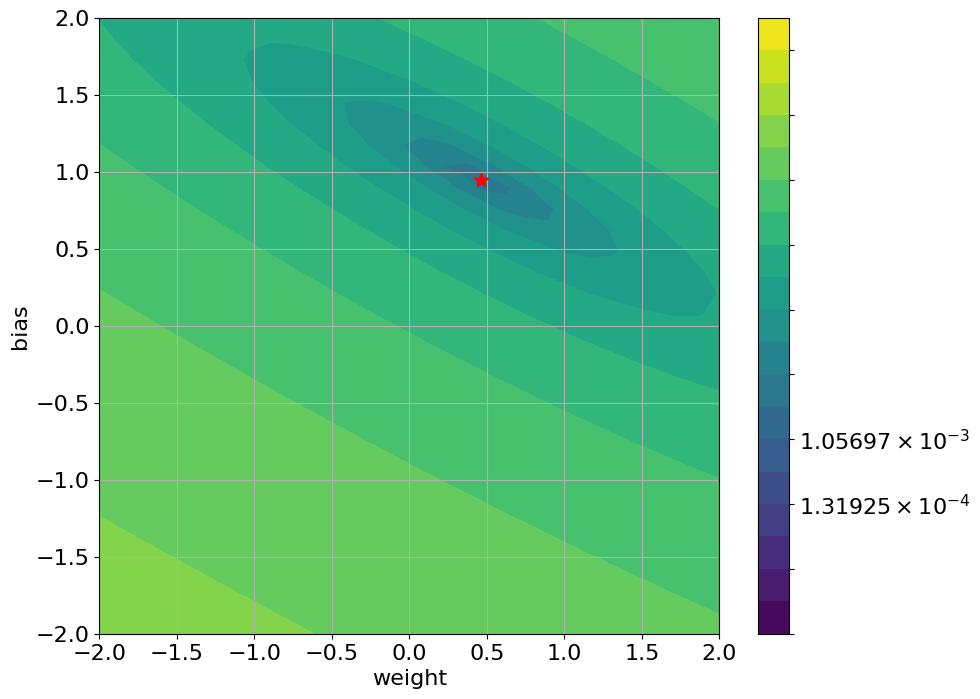

In [24]:
if input_dim == output_dim == 1:
    
    state_dict = model.state_dict()

    ww, bb = np.meshgrid(np.linspace(-2, 2, 30), np.linspace(-2, 2, 30))

    loss_values = 0 * ww
    for i in range(ww.shape[0]):
        for j in range(ww.shape[1]):
            state_dict['linear.weight'] = torch.tensor([[ww[i, j]]])
            state_dict['linear.bias'] = torch.tensor([bb[i, j]])
            model.load_state_dict(state_dict)
            loss_values[i, j] = loss_fun(model.forward(training_set.X),  training_set.y)

    fig = plt.figure(figsize=(10, 8))
    fig.clf()
    ax = fig.gca()
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    c=ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    plt.colorbar(c)
    ax.plot(A[0], b, 'r*', markersize=10)
    ax.set_ylabel('bias')
    ax.set_xlabel('weight')
    #ax.legend(['(A, b)'])
    
    ax.grid(True)    

## Optimization

Goal: minimize the loss given the data:
$$
\min\limits_{par \in model} L(X_{train}, y_{train})
=\min\limits_{par \in model} \frac{1}{n_{train}} \sum_{i=1}^{n_{train}} L(x_i, model(x_i))
$$

In this case $par =\{A, b\}$.

Iterative gradient based optimization:
\begin{align*}
par^{(0)} &= par_0\\
par^{(k+1)} &=  par^{(k)} - \eta^{(k)} \nabla_{par} L(X_{train}, y_{train})
\end{align*}    
with learning rate $\eta^{(k)}$.

## Gradients

The model is 
$$
model(x) = A x + b
$$

With $input\_dim = output\_dim = 1$ we have $A:=a\in\mathbb{R},\ b\in\mathbb{R}$. 

For a data pair $(x, y)$ the loss is
\begin{align*}
L(x, y) 
&= \|model(x)-y\|_2^2\\ 
&= (model(x)-y)^2\\
&= (a x + b - y)^2\\
&= a^2 x^2 + 2 a b x - 2 a xy + b^2 -2 b y + y^2.
\end{align*}

We can compute
\begin{align*}
\nabla_a L(x, y) 
&= 2 a x^2 + 2 b x - 2 xy
=2 x (a x + b - y)\\
\nabla_b L(x, y)
&= 2 a x + 2 b - 2 y
= 2 (ax + b - y).
\end{align*}


In [25]:
x = torch.randn(1, input_dim)
y =  torch.randn(1, output_dim)

model.zero_grad()
loss = loss_fun(model.forward(x),  y)
loss.backward()

In [26]:
if input_dim == output_dim == 1:
    print(model.linear.weight.grad)
    print(2 * x * (model.linear.weight * x + model.linear.bias - y))
    
    print(model.linear.bias.grad)
    print(2 * (model.linear.weight * x + model.linear.bias - y))

tensor([[30.7245]])
tensor([[30.7245]], grad_fn=<MulBackward0>)
tensor([14.2864])
tensor([[14.2864]], grad_fn=<MulBackward0>)


In [28]:
if input_dim == output_dim == 1:
    
    num_iter = 200
    lr = 0.5 # 0.01

    train_hist = {}
    train_hist['weight'] = []
    train_hist['bias'] = []

    model.reset()
    state_dict = model.state_dict()

    for _ in range(num_iter):

        model.zero_grad()
        loss = loss_fun(model.forward(training_set.X), training_set.y)
        loss.backward()

        w = model.linear.weight.item()
        b = model.linear.bias.item()

        dw = model.linear.weight.grad.item()
        db = model.linear.bias.grad.item()

        state_dict['linear.weight'] += torch.tensor([-lr * dw])
        state_dict['linear.bias'] += torch.tensor([-lr * db])
        model.load_state_dict(state_dict)

        train_hist['weight'].append(w)
        train_hist['bias'].append(b)

    for label in train_hist:
        train_hist[label] = np.array(train_hist[label])

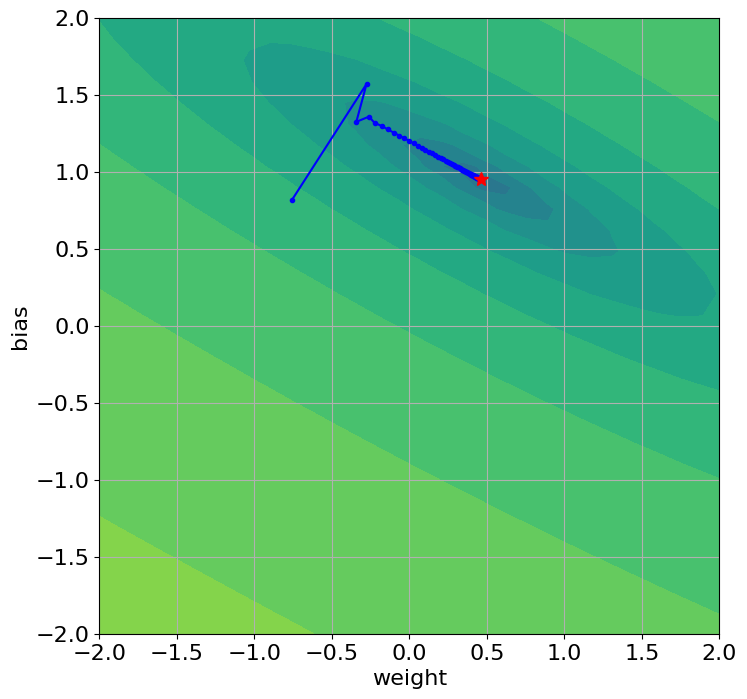

In [29]:
if input_dim == output_dim == 1:
    fig = plt.figure(figsize=(8, 8))
    fig.clf()
    ax = fig.gca()
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    ax.set_xlabel('weight')
    ax.set_ylabel('bias')
    ax.grid(True)
    ax.set_xlim(-2, 2) 
    ax.set_ylim(-2, 2) 
    
    ax.plot(train_hist['weight'], train_hist['bias'], '.-b')
    ax.plot(A[0], b, 'r*', markersize=10)

    #ax.legend(['optim', '(A, b)'])

### Stochastic GD

At every step, compute the loss on a batch of data $(X^{(k)}, y^{(k)})\sim (X_{train}, y_{train})$: 

\begin{align*}
L(X^{(k)}, y^{(k)}) := \sum_{(x, y) \in (X^{(k)}, y^{(k)})} L(x, model(x)).
\end{align*}    

and then update with this approximated gradient:
\begin{align*}
par^{(k+1)} &=  par^{(k)} - \eta^{(k)} \nabla_{par} L(X^{(k)}, y^{(k)}). 
\end{align*}    

### PyTorch `optim`

In [30]:
lr = 0.1
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [31]:
n_epochs = 100

In [32]:
train_hist = {}
train_hist['loss'] = []

if input_dim == output_dim == 1:
    train_hist['weight'] = []
    train_hist['bias'] = []

# Initialize training
model.reset()
model.train()

for epoch in range(n_epochs):
    for idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        loss = loss_fun(model.forward(batch[0]),  batch[1])
        loss.backward()
        optimizer.step()

        train_hist['loss'].append(loss.item())
        if input_dim == output_dim == 1:
            train_hist['weight'].append(model.linear.weight.item())
            train_hist['bias'].append(model.linear.bias.item())
        
        print('[Epoch %4d/%4d] [Batch %4d/%4d] Loss: % 2.2e' % (epoch + 1, n_epochs, 
                                                                idx + 1, len(train_loader), 
                                                                loss.item()))
        
model.eval()

[Epoch    1/ 100] [Batch    1/  10] Loss:  2.27e+00
[Epoch    1/ 100] [Batch    2/  10] Loss:  1.94e+00
[Epoch    1/ 100] [Batch    3/  10] Loss:  1.50e+00
[Epoch    1/ 100] [Batch    4/  10] Loss:  1.29e+00
[Epoch    1/ 100] [Batch    5/  10] Loss:  9.58e-01
[Epoch    1/ 100] [Batch    6/  10] Loss:  6.29e-01
[Epoch    1/ 100] [Batch    7/  10] Loss:  4.24e-01
[Epoch    1/ 100] [Batch    8/  10] Loss:  2.90e-01
[Epoch    1/ 100] [Batch    9/  10] Loss:  1.44e-01
[Epoch    1/ 100] [Batch   10/  10] Loss:  6.84e-02
[Epoch    2/ 100] [Batch    1/  10] Loss:  1.85e-02
[Epoch    2/ 100] [Batch    2/  10] Loss:  7.34e-03
[Epoch    2/ 100] [Batch    3/  10] Loss:  1.23e-02
[Epoch    2/ 100] [Batch    4/  10] Loss:  3.40e-02
[Epoch    2/ 100] [Batch    5/  10] Loss:  6.62e-02
[Epoch    2/ 100] [Batch    6/  10] Loss:  1.01e-01
[Epoch    2/ 100] [Batch    7/  10] Loss:  1.35e-01
[Epoch    2/ 100] [Batch    8/  10] Loss:  1.57e-01
[Epoch    2/ 100] [Batch    9/  10] Loss:  1.78e-01
[Epoch    2/

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [33]:
if input_dim == output_dim == 1:
    n_test = 500
    X_test = np.random.rand(n_test, input_dim)
    y_pred = []

    state_dict = model.state_dict()

    for idx in range(len(train_hist['weight'])):
        state_dict['linear.weight'] = torch.tensor([[train_hist['weight'][idx]]])
        state_dict['linear.bias'] = torch.tensor([train_hist['bias'][idx]])
        model.load_state_dict(state_dict)

        y_pred.append(model.forward(torch.tensor(X_test.astype('f'))).detach().numpy())    

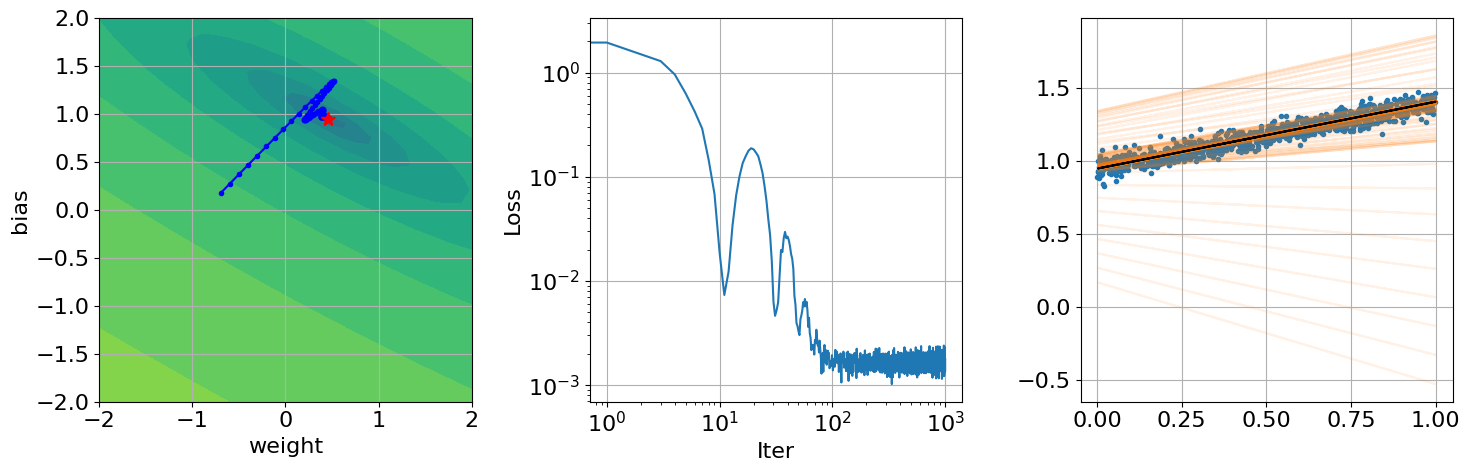

In [34]:
if input_dim == output_dim == 1:
    fig = plt.figure(figsize=(15, 5))
    fig.clf()
    
    ax = fig.add_subplot(1, 3, 1)
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    ax.plot(train_hist['weight'], train_hist['bias'], '.-b')
    ax.plot(A[0], b, 'r*', markersize=10)
    ax.set_xlabel('weight')
    ax.set_ylabel('bias')
    #ax.legend(['optim', '(A, b)'])
    ax.grid(True)
    ax.set_xlim(-2, 2) 
    ax.set_ylim(-2, 2) 
    
    ax = fig.add_subplot(1, 3, 2)
    ax.loglog(np.abs(train_hist['loss']))
    ax.set_xlabel('Iter')
    ax.set_ylabel('Loss')
    ax.grid(True)
    
    ax = fig.add_subplot(1, 3, 3)
    ax.plot(X_train, y_train, '.')
    a=ax.plot(X_test, y_pred[0], '-', alpha=0.1)
    for y in y_pred[1:]:
        ax.plot(X_test, y, '-', alpha=0.1, color=a[0].get_color())
    ax.plot(X_test, y_pred[-1], 'k')
    ax.grid(True)   

    fig.tight_layout()

else:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.loglog(np.abs(train_hist['loss']))
    ax.set_xlabel('Iter')
    ax.set_ylabel('Loss')
    ax.grid(True)